In [78]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 
import numpy as np

In [39]:
Image_size=256
Batch_size=32
Channels= 3
Epochs=50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "PlantVillage",
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size 
)

Found 2152 files belonging to 3 classes.


In [8]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

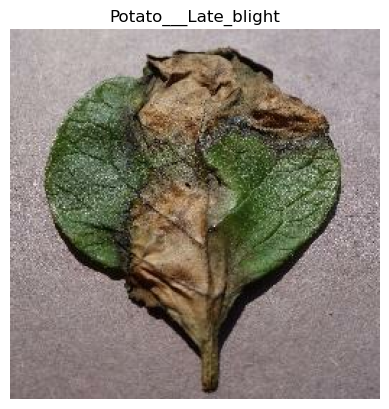

In [13]:
for image_batch, label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [24]:
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle =True,shuffle_size=1000):
    ds_size=len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split*ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [25]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [26]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [28]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size, Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [30]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [52]:
input_shape = (Batch_size, Image_size, Image_size, Channels)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation ='relu',input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation ='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation = 'relu'),
    layers.Dense(n_classes,activation='softmax')
])
model.build(input_shape=input_shape)

In [53]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 sequential_1 (Sequential)   (256, 256, 3)             0         
                                                                 
 conv2d_14 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [57]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [59]:
history=model.fit(
    train_ds,
    epochs=Epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50

54/54 [==============================] - 81s 1s/step - loss: 0.7319 - accuracy: 0.6910 - val_loss: 0.5574 - val_accuracy: 0.7552
Epoch 2/50
54/54 [==============================] - 66s 1s/step - loss: 0.4444 - accuracy: 0.8368 - val_loss: 0.3818 - val_accuracy: 0.8333
Epoch 3/50
54/54 [==============================] - 62s 1s/step - loss: 0.3254 - accuracy: 0.8744 - val_loss: 0.2994 - val_accuracy: 0.8802
Epoch 4/50
54/54 [==============================] - 62s 1s/step - loss: 0.2387 - accuracy: 0.9074 - val_loss: 0.4778 - val_accuracy: 0.8281
Epoch 5/50
54/54 [==============================] - 63s 1s/step - loss: 0.2413 - accuracy: 0.9109 - val_loss: 0.4627 - val_accuracy: 0.8177
Epoch 6/50
54/54 [==============================] - 63s 1s/step - loss: 0.1799 - accuracy: 0.9277 - val_loss: 0.1664 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 61s 1s/step - loss: 0.1313 - accuracy: 0.9554 - val_loss: 0.2015 - val_accuracy: 0.9010
Epoch 8/50
54/54 [=

In [60]:
scores =model.evaluate(test_ds)

8/8 [==============================] - 18s 563ms/step - loss: 0.1220 - accuracy: 0.9414


In [61]:
scores


[0.12201150506734848, 0.94140625]

In [64]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss= history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

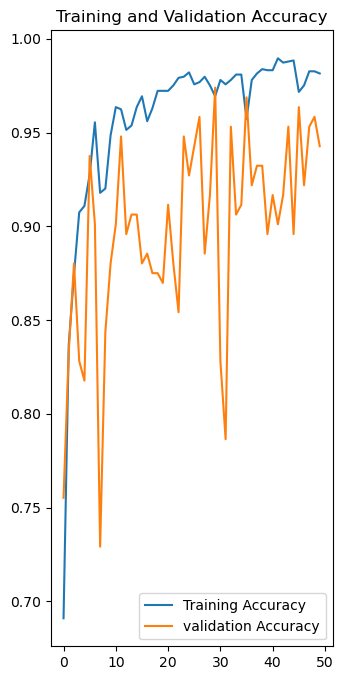

In [69]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(Epochs),acc, label='Training Accuracy')
plt.plot(range(Epochs),val_acc, label='validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

first image's actual label:  Potato___Early_blight
1/1 [==============================] - 0s 265ms/step
predicted label:  Potato___Late_blight


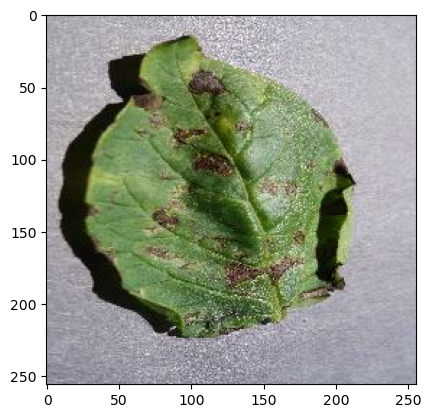

In [86]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    plt.imshow(first_image)
    print("first image's actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label: ",class_names[np.argmax(batch_prediction[0])])
    
    
                                              
                    

In [ ]:
model_version =1
model.save(f"../models/{model_version}")